# Events Table Traditional - Rainfall

__Description__: 
Calculates events for NOAA Atlas 14 expected rainfall data
- Median rainfall value based on the NOAA Atlas 14 

This notebook sequentially calculates 
- Rainfall values and probability weights for different return period events
- Rainfall event probability weights
- Hyetograph information for several distributions
    - NRCS
    - NOAA Atlas 14
   

__Input__: 
- Parameters: the volume, region, and duration ([See map for volume and region](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html)).
        
- The area averaged precipitation frequency data for the specified duration.


__Output__: 1 JSON file with the NRCS and NOAA event hyetographs and 1 JSON file with event weights. Additionally 4 DSS files with the the NRCS and NOAA rainfall hyetograph information is prepared. Intermediate csv and excel files are saved for reference.


---
## Load Libraries, Parameters, and Data:
### Libraries:

In [1]:
import sys
sys.path.append('../../core')
from hydromet import*
from hydromet_traditional import *
import hydromet_JSON_to_DSS
%matplotlib inline

### Parameters: 
#### Local (site specific):

In [2]:
Project_Area = 'salt_creek'          # Project area name
HUC = '071200040403'               # Domain huc number (e.g. 071200040505)

In [3]:
Return_Intervals = events_initialize('NOAA') # enter FEMA if you want to include SID84 frequencies only
duration = 24  # [hours]; Event duration;  must be a duration in the input Precip_Table file
Time_Extend = 12.0 # Model run time extension beyond the hyetograph (24-hour) period.
hyet_duration = duration+Time_Extend
hydrology_IDs = ['NRCS', 'NOAAQ1', 'NOAAQ2', 'NOAAQ3', 'NOAAQ4']  # ID's of the different hydrology scenarios considered. 
Aerial_Reduction = 1.0 #only use for large watersheds

forcing_type = 'Rainfall'

In [4]:
## Filenames and paths:
precip_table = '{0}_{1}_PrecipTable.xlsx'.format(Project_Area, HUC)  # NOAA Data
nrcs_precip_table = '{0}_{1}_nrcs_PrecipTable.xlsx'.format(Project_Area, HUC)  # NRCS Data
atlas14_precip_table = '{0}_{1}_atlas_temporal_PrecipTable.xlsx'.format(Project_Area, HUC)  # Atlas 14 Temporal Data

root_dir = pl.Path(os.getcwd())
outputs_dir = root_dir/'Outputs'
precip_table_dir = outputs_dir/precip_table
nrcs_precip_table_dir = outputs_dir/nrcs_precip_table   
atlas14_precip_table_dir = outputs_dir/atlas14_precip_table 
datarepository_dir = root_dir.parent.parent/'DataRepository'
bin_dir = root_dir.parent.parent/'bin'

## Options:
display_print = False
save_dss = True
remove_ind_dur = True                              # Remove individual duration files which are combined at the end of this notebook
run_dur_dic = {'24': 2, '36.0': 2}  # Run durations in days

##### Convert all paths to objects:

In [5]:
outputs_dir = pl.Path(outputs_dir)
precip_table_dir = pl.Path(precip_table_dir)
datarepository_dir = pl.Path(datarepository_dir)

### Data:
#### NOAA Atlas 14 precipitation values:

,Median,Lower (90%),Upper (90%)
Tr,,,
2,2.891592,2.574480,3.286755
5,3.701163,3.283337,4.207439
10,4.377602,3.863020,4.969184
25,5.377439,4.696378,6.100418
50,6.235949,5.403653,7.084265
100,7.189133,6.155010,8.170133
200,8.249031,6.967184,9.403857
500,9.851490,8.155633,11.288959
1000,11.241816,9.135367,12.981429


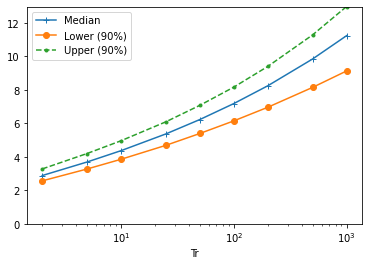

In [6]:
raw_precip = get_input_data(precip_table_dir, duration, Return_Intervals[0], display_print)
raw_precip.rename(columns = {'Expected Value': 'Median'}, inplace = True)
raw_precip.plot(style=['+-','o-','.--'], logx=True, ylim=(0, raw_precip['Upper (90%)'].max()))
raw_precip.head(10)

---
## NRCS

#### Rainfall Forcing Data:

In [7]:
hid = 0
## Reduce precipitation by aerial reduction factor:
raw_precip_reduced = raw_precip[raw_precip.select_dtypes(include=['number']).columns]*Aerial_Reduction

#events and precip curves
prep_curves, t_step = precip_distributed_nrcs(Return_Intervals,nrcs_precip_table_dir,
                     raw_precip_reduced)
final_curves = extend_time(prep_curves,Time_Extend,t_step)

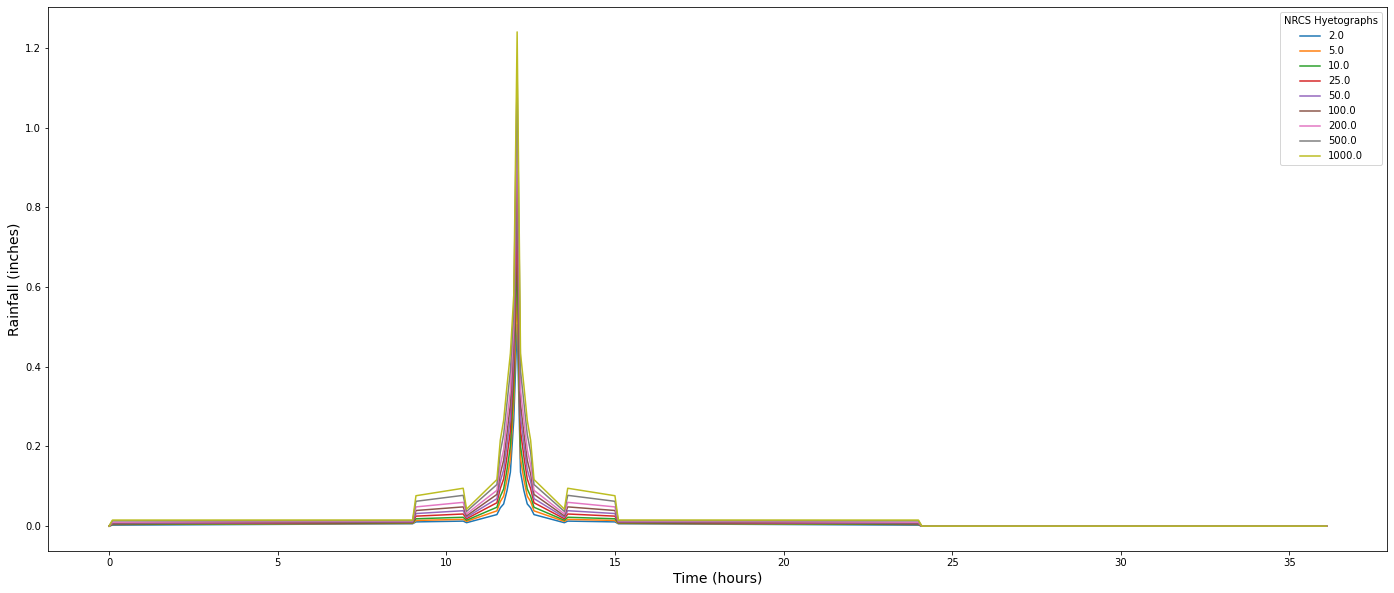

In [8]:
## test plot:
t_p = final_curves.plot(figsize=(24, 10))
t_p.legend(title='NRCS Hyetographs')
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Rainfall (inches)', fontsize=14)
t_p.plot();

#### Hydrology Weights:

In [9]:
#formatting
Event_Weights_Hydro = weights_noaa(Return_Intervals)

In [10]:
renamed_weights = {}
rename_map = {}

for k,v in zip(Return_Intervals,Event_Weights_Hydro):
    renamed_weights[hydrology_IDs[hid]+'_'+str(k)] = v
    rename_map[k] = hydrology_IDs[hid]+'_'+str(k)

In [11]:
renamed_curves = final_curves.rename(columns=rename_map).copy()
renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)
renamed_curves.head(2)

,NRCS_2,NRCS_5,NRCS_10,NRCS_25,NRCS_50,NRCS_100,NRCS_200,NRCS_500,NRCS_1000
hours,,,,,,,,,
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.1,0.002389,0.004094,0.004321,0.005926,0.006611,0.008047,0.009695,0.013256,0.015114


In [12]:
#convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight':list(renamed_weights.values())}, index = list(renamed_weights.keys())) 

### Save Data

##### To CSV:

In [13]:
renamed_curves.to_csv(outputs_dir/'Rainfall_{0}_Dur{1}_{2}.csv'.format(HUC, duration,hydrology_IDs[hid]))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_{2}.csv'.format(HUC, duration, hydrology_IDs[hid]))

In [14]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'Rainfall_{0}_{1}_{2}.xlsx'.format(Project_Area, HUC, hydrology_IDs[hid]))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.save()

---
## NOAA

*Rainfall totals are the same as NRCS*

#### Quartile 1 Rainfall Forcing Data:

In [15]:
hid = 1
#events and precip curves
prep_curves, t_step = precip_distributed_atlas(Return_Intervals,atlas14_precip_table_dir,
                     raw_precip_reduced,hid)
final_curves = extend_time(prep_curves,Time_Extend,t_step)

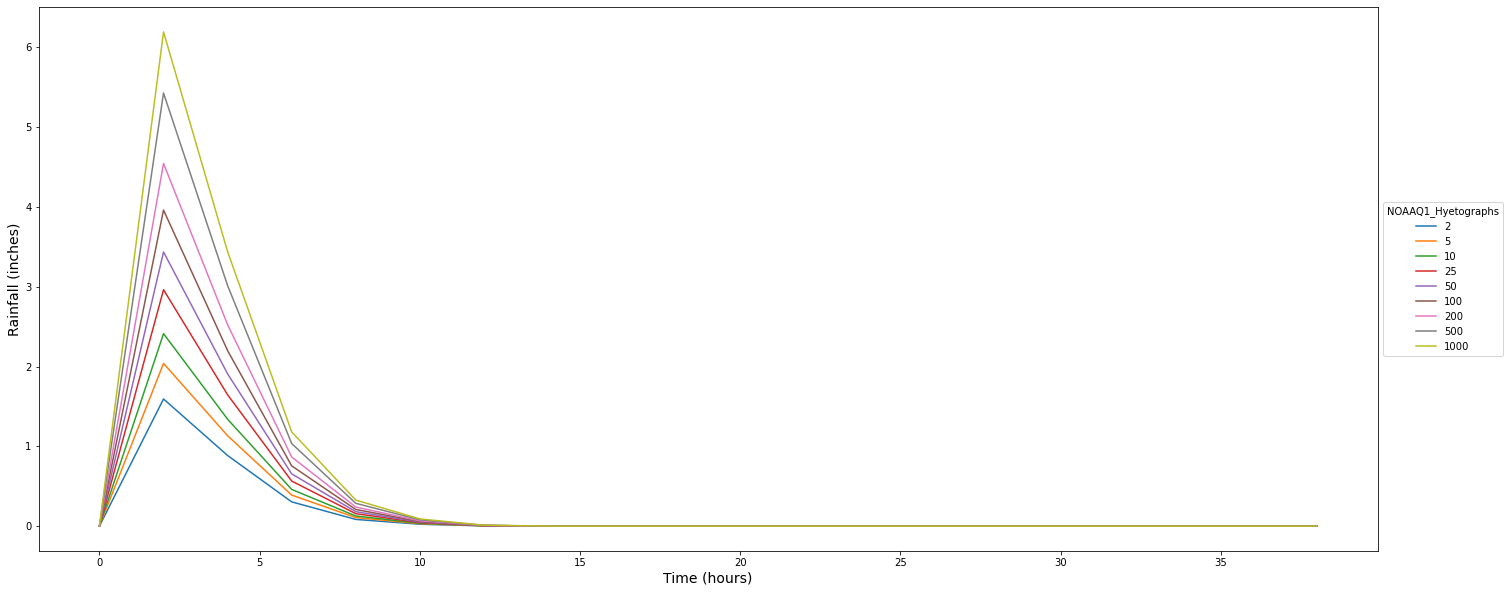

In [16]:
## graph
t_p = final_curves.plot(figsize=(24,10))
t_p.legend(title=hydrology_IDs[hid]+'_Hyetographs',loc='center left', bbox_to_anchor=(1.0, 0.5))
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Rainfall (inches)', fontsize=14)
t_p.plot();

In [17]:
#formatting
renamed_weights = {}
rename_map = {}

for k,v in zip(Return_Intervals,Event_Weights_Hydro):
    renamed_weights[hydrology_IDs[hid]+'_'+str(k)] = v
    rename_map[k] = hydrology_IDs[hid]+'_'+str(k)


renamed_curves = final_curves.rename(columns=rename_map).copy()
renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)

In [18]:
## Convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight': list(renamed_weights.values())}, index = list(renamed_weights.keys())) 

### Save

##### To CSV:

In [19]:
renamed_curves.to_csv(outputs_dir/'Rainfall_{0}_Dur{1}_{2}.csv'.format(HUC, duration,hydrology_IDs[hid]))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_{2}.csv'.format(HUC, duration, hydrology_IDs[hid]))

In [20]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'Rainfall_{0}_{1}_{2}.xlsx'.format(Project_Area, HUC, hydrology_IDs[hid]))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.save()

#### Quartile 2 Rainfall Forcing Data:

In [21]:
hid = 2
#events and precip curves
prep_curves, t_step = precip_distributed_atlas(Return_Intervals,atlas14_precip_table_dir,
                     raw_precip_reduced,hid)
final_curves = extend_time(prep_curves,Time_Extend,t_step)

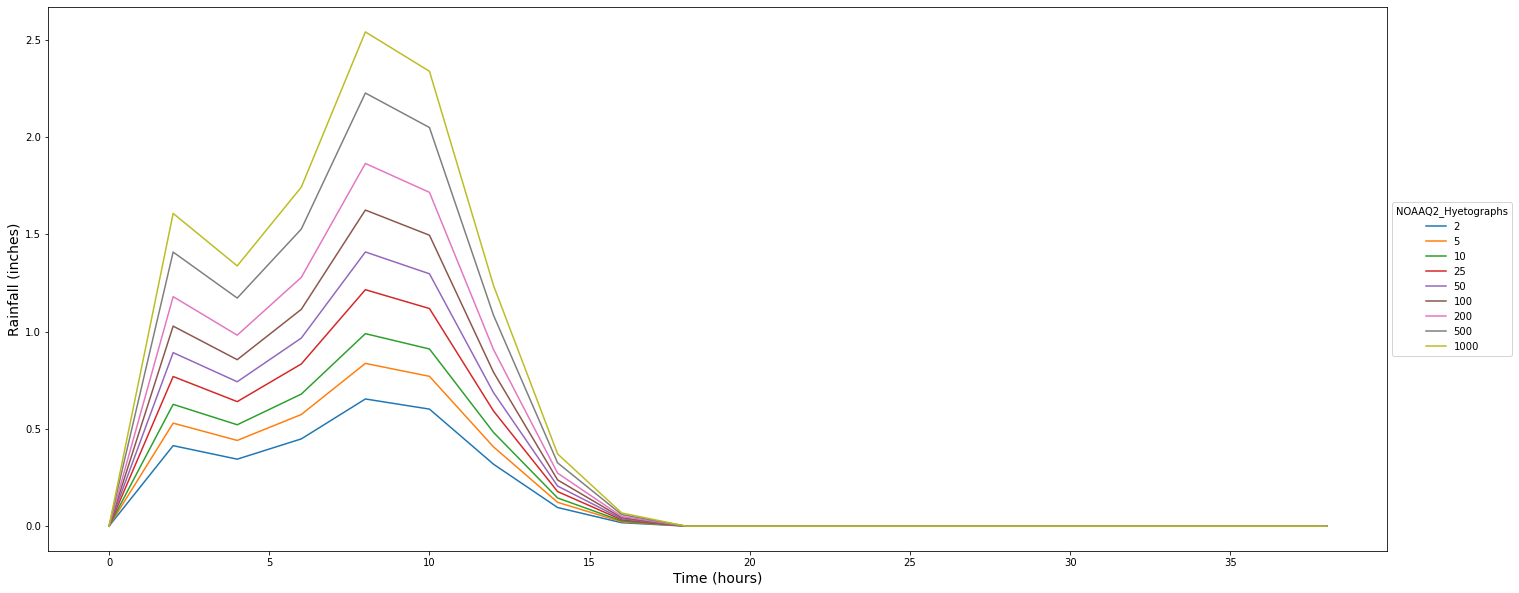

In [22]:
## graph
t_p = final_curves.plot(figsize=(24,10))
t_p.legend(title=hydrology_IDs[hid]+'_Hyetographs',loc='center left', bbox_to_anchor=(1.0, 0.5))
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Rainfall (inches)', fontsize=14)
t_p.plot();

In [23]:
#formatting
renamed_weights = {}
rename_map = {}

for k,v in zip(Return_Intervals,Event_Weights_Hydro):
    renamed_weights[hydrology_IDs[hid]+'_'+str(k)] = v
    rename_map[k] = hydrology_IDs[hid]+'_'+str(k)


renamed_curves = final_curves.rename(columns=rename_map).copy()
renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)

In [24]:
## Convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight': list(renamed_weights.values())}, index = list(renamed_weights.keys())) 

### Save

##### To CSV:

In [25]:
renamed_curves.to_csv(outputs_dir/'Rainfall_{0}_Dur{1}_{2}.csv'.format(HUC, duration,hydrology_IDs[hid]))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_{2}.csv'.format(HUC, duration, hydrology_IDs[hid]))

In [26]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'Rainfall_{0}_{1}_{2}.xlsx'.format(Project_Area, HUC, hydrology_IDs[hid]))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.save()

#### Quartile 3 Rainfall Forcing Data:

In [27]:
hid = 3
#events and precip curves
prep_curves, t_step = precip_distributed_atlas(Return_Intervals,atlas14_precip_table_dir,
                     raw_precip_reduced,hid)
final_curves = extend_time(prep_curves,Time_Extend,t_step)

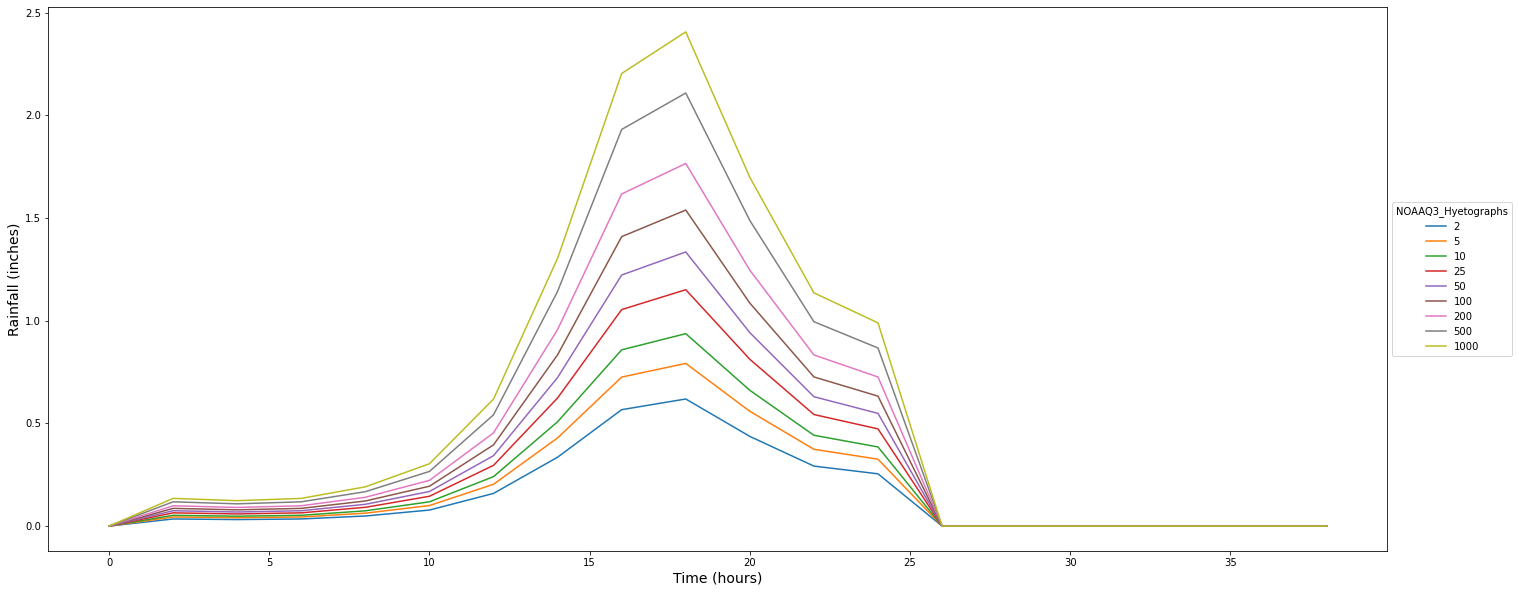

In [28]:
## graph
t_p = final_curves.plot(figsize=(24,10))
t_p.legend(title=hydrology_IDs[hid]+'_Hyetographs',loc='center left', bbox_to_anchor=(1.0, 0.5))
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Rainfall (inches)', fontsize=14)
t_p.plot();

In [29]:
#formatting
renamed_weights = {}
rename_map = {}

for k,v in zip(Return_Intervals,Event_Weights_Hydro):
    renamed_weights[hydrology_IDs[hid]+'_'+str(k)] = v
    rename_map[k] = hydrology_IDs[hid]+'_'+str(k)


renamed_curves = final_curves.rename(columns=rename_map).copy()
renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)

In [30]:
## Convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight': list(renamed_weights.values())}, index = list(renamed_weights.keys())) 

### Save

##### To CSV:

In [31]:
renamed_curves.to_csv(outputs_dir/'Rainfall_{0}_Dur{1}_{2}.csv'.format(HUC, duration,hydrology_IDs[hid]))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_{2}.csv'.format(HUC, duration, hydrology_IDs[hid]))

In [32]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'Rainfall_{0}_{1}_{2}.xlsx'.format(Project_Area, HUC, hydrology_IDs[hid]))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.save()

#### Quartile 4 Rainfall Forcing Data:

In [33]:
hid = 4
#events and precip curves
prep_curves, t_step = precip_distributed_atlas(Return_Intervals,atlas14_precip_table_dir,
                     raw_precip_reduced,hid)
final_curves = extend_time(prep_curves,Time_Extend,t_step)

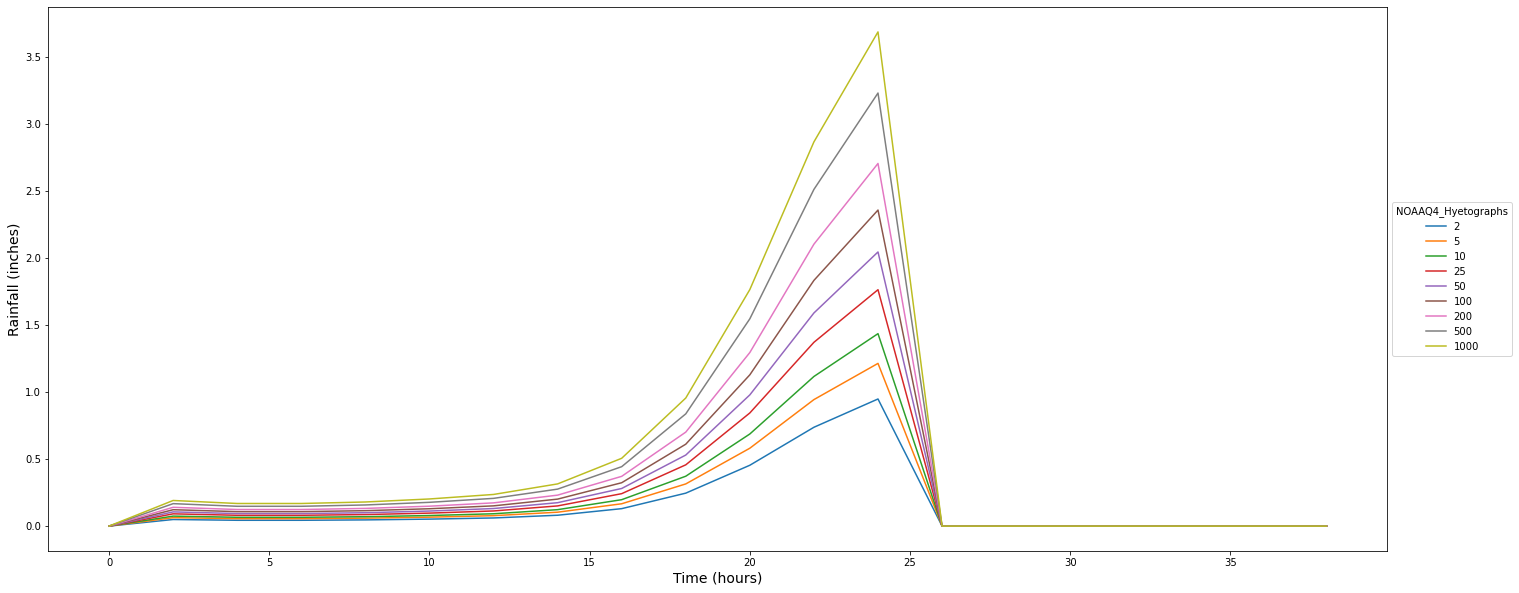

In [34]:
## graph
t_p = final_curves.plot(figsize=(24,10))
t_p.legend(title=hydrology_IDs[hid]+'_Hyetographs',loc='center left', bbox_to_anchor=(1.0, 0.5))
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Rainfall (inches)', fontsize=14)
t_p.plot();

In [35]:
#formatting
renamed_weights = {}
rename_map = {}

for k,v in zip(Return_Intervals,Event_Weights_Hydro):
    renamed_weights[hydrology_IDs[hid]+'_'+str(k)] = v
    rename_map[k] = hydrology_IDs[hid]+'_'+str(k)


renamed_curves = final_curves.rename(columns=rename_map).copy()
renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)

In [36]:
## Convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight': list(renamed_weights.values())}, index = list(renamed_weights.keys())) 

### Save

##### To CSV:

In [37]:
renamed_curves.to_csv(outputs_dir/'Rainfall_{0}_Dur{1}_{2}.csv'.format(HUC, duration,hydrology_IDs[hid]))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_{2}.csv'.format(HUC, duration, hydrology_IDs[hid]))

In [38]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'Rainfall_{0}_{1}_{2}.xlsx'.format(Project_Area, HUC, hydrology_IDs[hid]))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.save()

## Save Outputs to JSON and DSS

### Rainfall Forcing Data

In [39]:
rainfall_dic = combine_results_stratified(forcing_type, outputs_dir, HUC, duration, hydrology_IDs, run_dur_dic, remove_ind_dur=True)

with open(outputs_dir/'{0}_{1}_{2}.json'.format(Project_Area, HUC, forcing_type), 'w') as f:
    json.dump(rainfall_dic, f)
    
forcing = '{0}_{1}_{2}'.format(Project_Area, HUC,forcing_type)
jsonname = '{0}_{1}_{2}.json'.format(Project_Area, HUC, forcing_type)

In [40]:
hydromet_JSON_to_DSS.main(outputs_dir, outputs_dir, bin_dir, forcing, jsonname, variable = 'Rainfall')

Converting salt_creek_071200040403_Rainfall.json to DSS...
Dss File written to C:\Users\cusmith\OneDrive - Stantec Office 365\git\Hydromet\notebooks\pluvial\Outputs\salt_creek_071200040403_Rainfall_NRCS.dss
Dss File written to C:\Users\cusmith\OneDrive - Stantec Office 365\git\Hydromet\notebooks\pluvial\Outputs\salt_creek_071200040403_Rainfall_NOAAQ1.dss
Dss File written to C:\Users\cusmith\OneDrive - Stantec Office 365\git\Hydromet\notebooks\pluvial\Outputs\salt_creek_071200040403_Rainfall_NOAAQ2.dss
Dss File written to C:\Users\cusmith\OneDrive - Stantec Office 365\git\Hydromet\notebooks\pluvial\Outputs\salt_creek_071200040403_Rainfall_NOAAQ3.dss
Dss File written to C:\Users\cusmith\OneDrive - Stantec Office 365\git\Hydromet\notebooks\pluvial\Outputs\salt_creek_071200040403_Rainfall_NOAAQ4.dss


### Weights

In [41]:
weights_dic = combine_results_traditional('Weights',  outputs_dir, HUC, duration, hydrology_IDs, run_dur_dic, remove_ind_dur=False)

with open(outputs_dir/'{0}_{1}_Weights.json'.format(Project_Area, HUC), 'w') as f:
    json.dump(weights_dic, f)

---
# End